# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
# %pip install optuna
# %pip install belashovplot
# %pip install timm

# Импорты и настройка модулей

In [3]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump, load
import torch
import numpy
import timm
import pandas
from copy import deepcopy

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (6.69291, 10.1181-1.0)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA GeForce RTX 3060 Ti


# Отображение результатов обучения

## Список файлов

In [6]:
filenames = [
    "Trained ID2NN base.pkl",
    "Trained ID2NN HSC.pkl",
    "Trained ID2NN HSC2.pkl",
]
spatial_coherence_list = [
    50.0E-6,
    1000.0E-6,
    3000.0E-6,
]
length = 5.0E-3
filesamount = len(filenames)
# model, dataset, loss_function_proportion, optimizer_type, (incoherent, chunker, optical, detectors, electronic), loss_histories, cofusion_matrixes

## Матрицы ошибок и данные о точности

In [7]:
confusion_matrixes_list = []
incoherent_sample_list = []
for filename in filenames:
    with open(filename, 'rb') as file:
        _, _, _, _, (incoherent, _, _, _, _), _, confusion_matrixes = load(file)
        confusion_matrixes_list.append(confusion_matrixes)
        incoherent_sample_list.append(incoherent.sample()[0].cpu())
        incoherent = None
        confusion_matrixes = None
        _ = None
# model, dataset, loss_function_proportion, optimizer_type, (incoherent, chunker, optical, detectors, electronic), loss_histories, cofusion_matrixes

In [8]:
use_epochs_mean = 20
accuracies_list = []
mean_accuracy_list = []
last_confusion_matrix_list = []
for confusion_matrixes in confusion_matrixes_list:
    last_confusion_matrix_list.append(confusion_matrixes[-1])
    accuracies = []
    for confusion_matrix in confusion_matrixes:
        accuracies.append(100*numpy.sum(numpy.diagonal(confusion_matrix, 0))/numpy.sum(confusion_matrix))
    accuracies_list.append(numpy.array(accuracies))
    accuracies = None
    mean_accuracy_list.append(numpy.mean(accuracies_list[-1][-10:]))
print([accuracies.shape for accuracies in accuracies_list])

[(61,), (61,), (61,)]


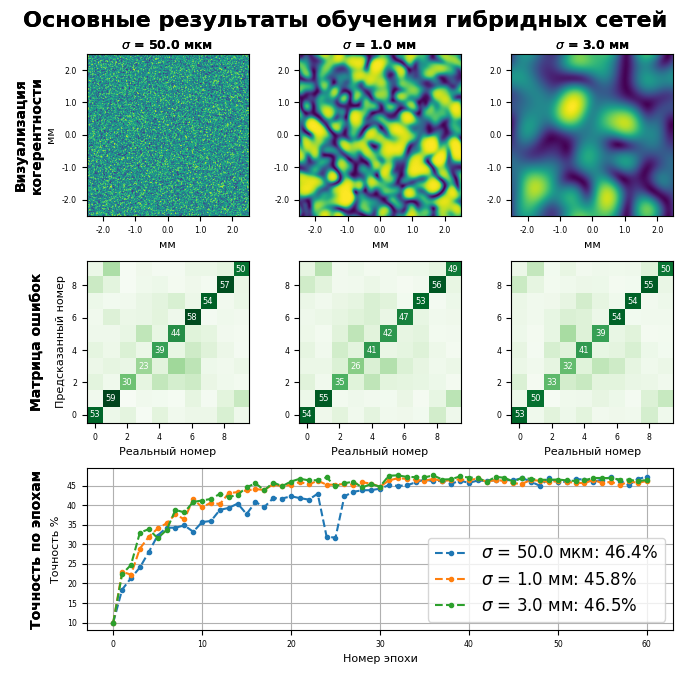

In [9]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = deepcopy(FontLibrary)
plot.FontLibrary.Fonts.RowDescriptionLeft.FontSize = 10
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.1)
matrix_font = plot.FontLibrary.Fonts.GraphDescription
matrix_font.HorizontalAlignment = 'center'
matrix_font.VerticalAlignment = 'center'
matrix_font.Color = 'white'
matrix_font.FontSize = 6
plot.title("Основные результаты обучения гибридных сетей")

plot.description.row.left("Точность по эпохам", 2)
axes = plot.axes.add((0, 2), (filesamount-1, 2))
plot.graph.label.x("Номер эпохи")
plot.graph.label.y("Точность %")
axes.grid(True)
for i, (accuracies, mean_accuracy, spatial_coherence) in enumerate(zip(accuracies_list, mean_accuracy_list, spatial_coherence_list)):
    epochs = numpy.arange(accuracies.shape[0])
    line = axes.plot(epochs, accuracies, marker='o', ms=3.0, linestyle='--', label=f"$\\sigma$ = {engineering(spatial_coherence, 'м', 0)}: {round(mean_accuracy, 1)}%")
    # axes.axhline(mean_accuracy, c=line[0].get_c(), linestyle='--', linewidth=1.0)
    line = None
axes.legend(loc='lower right', fontsize= 'large')

formatter, unit = engineering.separatedformatter(length/2, 'м')
plot.description.row.left("Матрица ошибок", 1)
plot.description.row.left("Визуализация когерентности", 0)
confusion_max, confusion_min = 0, 100
confusion_min = 0
for last_confusion_matrix in last_confusion_matrix_list:
    temp = 100*last_confusion_matrix/numpy.sum(last_confusion_matrix, axis=1)
    maximum = numpy.max(temp)
    minimum = numpy.min(temp)
    confusion_max = max(confusion_max, maximum)
    confusion_min = min(confusion_min, minimum)
for col, (spatial_coherence, last_confusion_matrix, incoherent_sample) in enumerate(zip(spatial_coherence_list, last_confusion_matrix_list, incoherent_sample_list)):
    axes = plot.axes.add(col, 0)
    plot.description.column.top(f"$\\sigma$ = {engineering(spatial_coherence, 'м', 0)}", col)
    plot.graph.label.x(unit)
    if col == 0:
        plot.graph.label.y(unit)
    axes.imshow(incoherent_sample, aspect='auto', extent=[-length/2, +length/2]*2)
    axes.xaxis.set_major_formatter(formatter)
    axes.yaxis.set_major_formatter(formatter)

    temp = 100*last_confusion_matrix/numpy.sum(last_confusion_matrix, axis=1)
    axes = plot.axes.add(col, 1)
    axes.imshow(temp, aspect='auto', interpolation='nearest', cmap='Greens', origin='lower', vmin=confusion_min, vmax=confusion_max)
    plot.graph.label.x('Реальный номер')
    if col == 0:
        plot.graph.label.y('Предсказанный номер')
    for i, percent in enumerate(temp.diagonal()):
        axes.text(i,i, f"{int(percent)}", matrix_font.Pass())

plot.save('../../figures/ModelResults.pdf')
plot.show()

## Визуализация весов модуляторов

In [10]:
optical_list = []
for filename in filenames:
    with open(filename, 'rb') as file:
        _, _, _, _, (_, _, optical, _, _), _, _ = load(file)
        optical_list.append(optical)
        optical = None
        _ = None
# model, dataset, loss_function_proportion, optimizer_type, (incoherent, chunker, optical, detectors, electronic), loss_histories, cofusion_matrixes

In [11]:
masks_amplitudes_list = []
masks_phases_list = []
for optical in optical_list:
    masks_amplitudes = []
    masks_phases = []
    for mask in optical._elements:
        if isinstance(mask, AmplitudeModulator):
            masks_amplitudes.append(mask._multiplier().abs().detach().cpu().squeeze().numpy())
        elif isinstance(mask, PhaseModulator):
            masks_phases.append(mask._multiplier().angle().detach().cpu().squeeze().numpy())
    masks_amplitudes_list.append(masks_amplitudes)
    masks_phases_list.append(masks_phases)

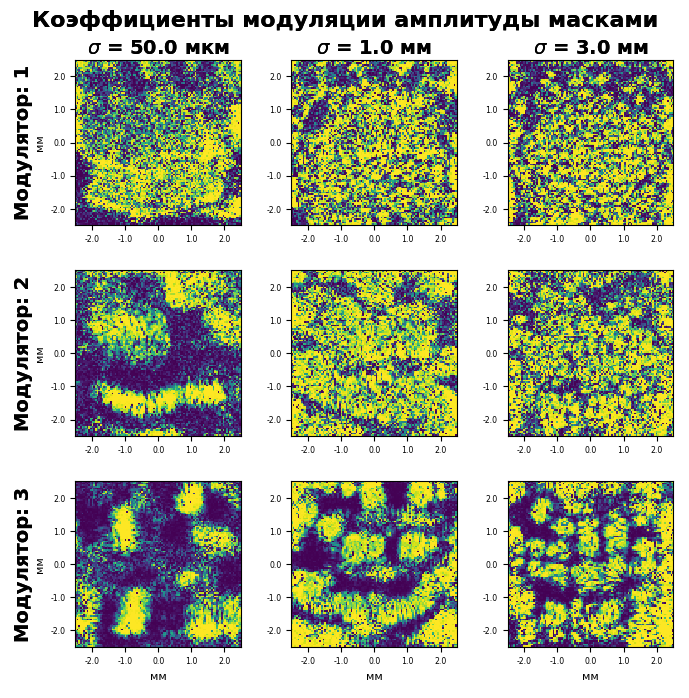

In [12]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = deepcopy(FontLibrary)
plot.FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 14
plot.FontLibrary.Fonts.RowDescriptionLeft.FontSize = 14
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.1)
plot.title("Коэффициенты модуляции амплитуды масками")

formatter, unit = engineering.separatedformatter(length/2, 'м')

for row, amplitude in enumerate(masks_amplitudes_list[0]):
    plot.description.row.left(f"Модулятор: {row+1}", row)
for col, (spatial_coherence, amplitude_masks) in enumerate(zip(spatial_coherence_list, masks_amplitudes_list)):
    plot.description.column.top(f"$\\sigma$ = {engineering(spatial_coherence, 'м', 0)}", col)
    for row, amplitude in enumerate(amplitude_masks):
        axes = plot.axes.add(col, row)
        axes.imshow(amplitude, aspect='auto', extent=[-length/2, +length/2]*2, interpolation='nearest')
        if row == len(amplitude_masks) - 1:
            plot.graph.label.x(unit)
        if col == 0:
            plot.graph.label.y(unit)
        axes.xaxis.set_major_formatter(formatter)
        axes.yaxis.set_major_formatter(formatter)
        
plot.save('../../figures/ModelAmplitude.pdf')
plot.show()

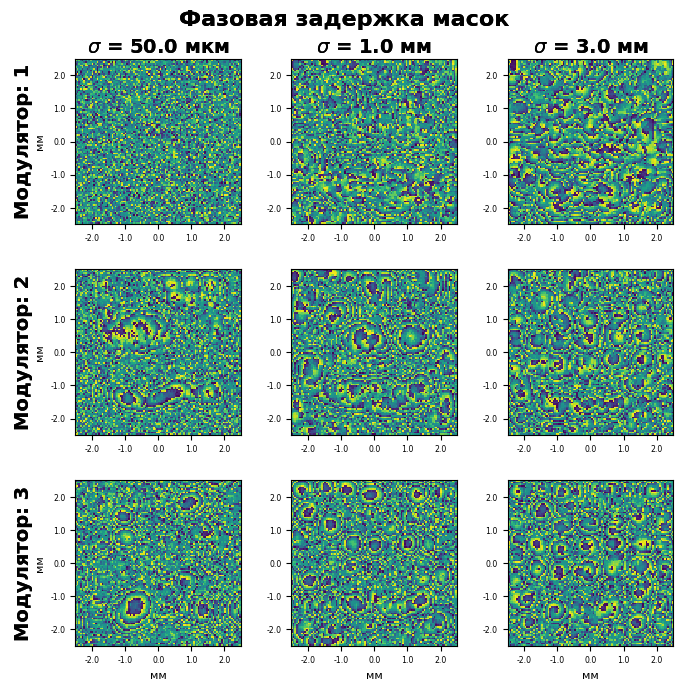

In [13]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = deepcopy(FontLibrary)
plot.FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 14
plot.FontLibrary.Fonts.RowDescriptionLeft.FontSize = 14
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.1)
plot.title("Фазовая задержка масок")

formatter, unit = engineering.separatedformatter(length/2, 'м')

for row, phase in enumerate(masks_phases_list[0]):
    plot.description.row.left(f"Модулятор: {row+1}", row)
for col, (spatial_coherence, phase_masks) in enumerate(zip(spatial_coherence_list, masks_phases_list)):
    plot.description.column.top(f"$\\sigma$ = {engineering(spatial_coherence, 'м', 0)}", col)
    for row, phase in enumerate(phase_masks):
        axes = plot.axes.add(col, row)
        axes.imshow(phase, aspect='auto', extent=[-length/2, +length/2]*2, interpolation='nearest')
        if row == len(phase_masks) - 1:
            plot.graph.label.x(unit)
        if col == 0:
            plot.graph.label.y(unit)
        axes.xaxis.set_major_formatter(formatter)
        axes.yaxis.set_major_formatter(formatter)
        
plot.save('../../figures/ModelPhase.pdf')
plot.show()

## Распространение через систему

In [14]:
optical_list = []
detectors_list = []
electronic_list = []
dataset = None
for filename in filenames:
    with open(filename, 'rb') as file:
        _, dataset, _, _, (_, _, optical, detectors, electronic), _, _ = load(file)
        optical_list.append(optical)
        detectors_list.append(detectors)
        electronic_list.append(electronic)
        dataset = dataset
        optical = None
        detectors = None
        electronic = None
        _ = None
# model, dataset, loss_function_proportion, optimizer_type, (incoherent, chunker, optical, detectors, electronic), loss_histories, cofusion_matrixes

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 73.79it/s]


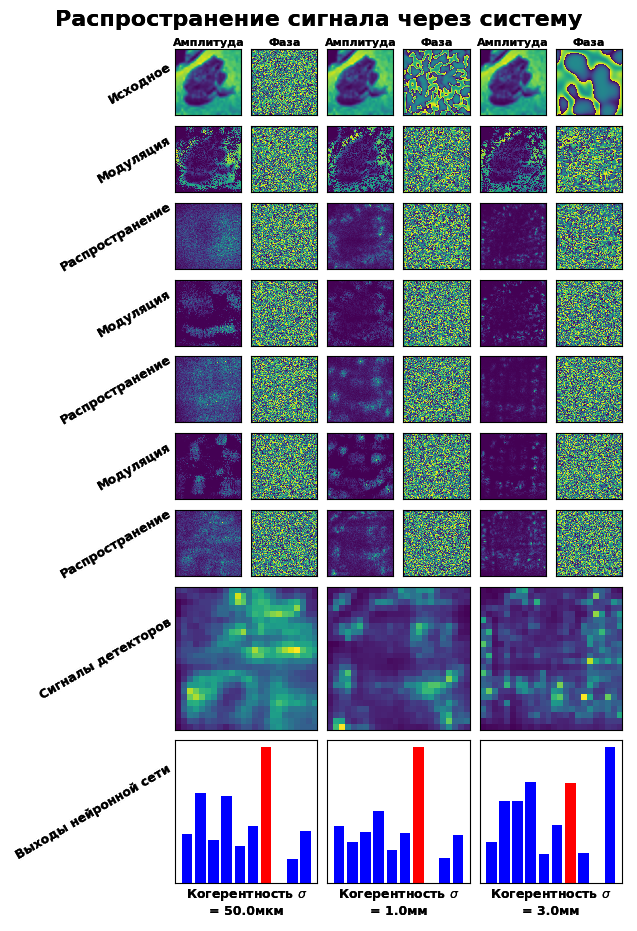

In [23]:
image, label = next(iter(dataset.test))
image, label = image[0].unsqueeze(0).to(optical_list[0].device), label[0].to(optical_list[0].device)
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = deepcopy(FontLibrary)
plot.FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 8
plot.FontLibrary.Fonts.RowDescriptionRight.FontSize = 10
plot.FontLibrary.Fonts.RowDescriptionLeft.Rotation = 30
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.1)
plot.title("Распространение сигнала через систему")

with torch.no_grad():
    for col, (spatial_coherence, optical, detectors, electronic) in enumerate(zip(spatial_coherence_list, optical_list, detectors_list, electronic_list)):
        col0 = 2*col
        col1 = col0 + 1

        plot.description.column.bottom(f"Когерентность $\\sigma$ = {engineering(spatial_coherence, 'м', 0, space='')}", col0, col1)
        plot.description.column.top("Амплитуда", col0)
        plot.description.column.top("Фаза", col1)
        
        planes_ = optical.planes(image, image.shape[2], image.shape[3])
        planes = [planes_[0]] + [x for i, x in enumerate(planes_[1:]) if i % 3 != 0]
        for row, plane in enumerate(planes):
            if col == 0:
                if row == 0:
                    plot.description.row.left("Исходное", row)
                elif row % 2 == 0:
                    plot.description.row.left("Распространение", row)
                else:
                    plot.description.row.left("Модуляция", row)
            axes = plot.axes.add(col0, row)
            axes.imshow(plane.squeeze().cpu().abs(), aspect='auto', interpolation='nearest')
            axes.set_xticks([])
            axes.set_yticks([])
            
            axes = plot.axes.add(col1, row)
            axes.imshow(plane.squeeze().cpu().angle(), aspect='auto', interpolation='nearest')
            axes.set_xticks([])
            axes.set_yticks([])

        if col == 0:
            plot.description.row.left("Сигналы детекторов", row+1, row+2)
            plot.description.row.left("Выходы нейронной сети", row+3, row+4)
            
        signals = detectors.forward(optical.forward(image))
        axes = plot.axes.add((col0, row+1), (col1, row+2))
        axes.set_xticks([])
        axes.set_yticks([])
        axes.imshow(signals.squeeze().cpu(), aspect='auto', interpolation='nearest')
        
        results = electronic.forward(signals)
        colors = ['blue']*results.squeeze().shape[0]
        colors[label] = 'red'
        axes = plot.axes.add((col0, row+3), (col1, row+4))
        axes.set_xticks([])
        axes.set_yticks([])
        axes.bar(numpy.arange(results.squeeze().shape[0]), ((results - results.min())/(results.max() - results.min())).squeeze().cpu(), color=colors)
        
plot.save('../../figures/ModelWork1.pdf')
plot.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 91.87it/s]


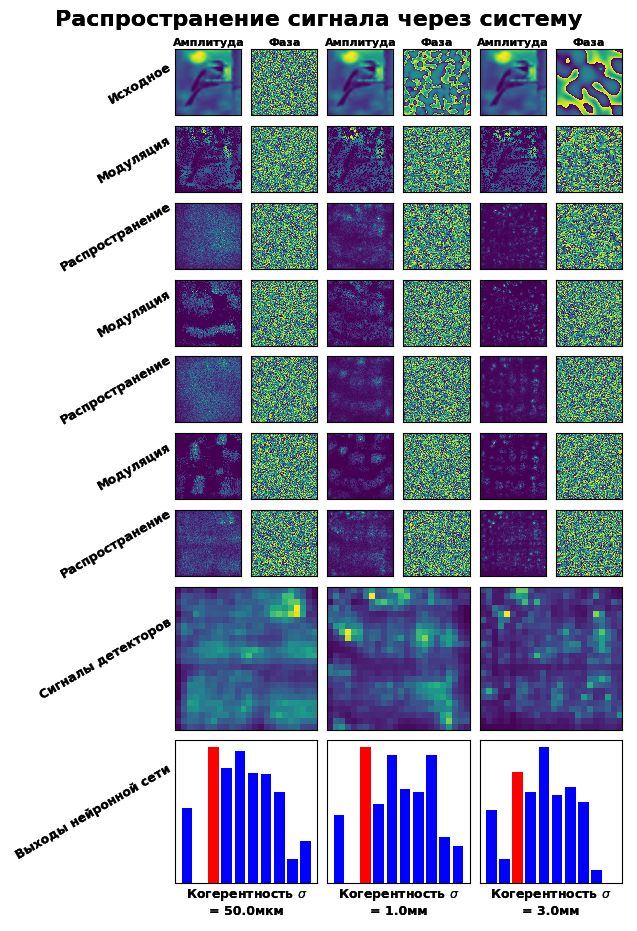

In [26]:
image, label = next(iter(dataset.test))
image, label = image[0].unsqueeze(0).to(optical_list[0].device), label[0].to(optical_list[0].device)
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = deepcopy(FontLibrary)
plot.FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 8
plot.FontLibrary.Fonts.RowDescriptionRight.FontSize = 10
plot.FontLibrary.Fonts.RowDescriptionLeft.Rotation = 30
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.1)
plot.title("Распространение сигнала через систему")

with torch.no_grad():
    for col, (spatial_coherence, optical, detectors, electronic) in enumerate(zip(spatial_coherence_list, optical_list, detectors_list, electronic_list)):
        col0 = 2*col
        col1 = col0 + 1

        plot.description.column.bottom(f"Когерентность $\\sigma$ = {engineering(spatial_coherence, 'м', 0, space='')}", col0, col1)
        plot.description.column.top("Амплитуда", col0)
        plot.description.column.top("Фаза", col1)
        
        planes_ = optical.planes(image, image.shape[2], image.shape[3])
        planes = [planes_[0]] + [x for i, x in enumerate(planes_[1:]) if i % 3 != 0]
        for row, plane in enumerate(planes):
            if col == 0:
                if row == 0:
                    plot.description.row.left("Исходное", row)
                elif row % 2 == 0:
                    plot.description.row.left("Распространение", row)
                else:
                    plot.description.row.left("Модуляция", row)
            axes = plot.axes.add(col0, row)
            axes.imshow(plane.squeeze().cpu().abs(), aspect='auto', interpolation='nearest')
            axes.set_xticks([])
            axes.set_yticks([])
            
            axes = plot.axes.add(col1, row)
            axes.imshow(plane.squeeze().cpu().angle(), aspect='auto', interpolation='nearest')
            axes.set_xticks([])
            axes.set_yticks([])

        if col == 0:
            plot.description.row.left("Сигналы детекторов", row+1, row+2)
            plot.description.row.left("Выходы нейронной сети", row+3, row+4)
            
        signals = detectors.forward(optical.forward(image))
        axes = plot.axes.add((col0, row+1), (col1, row+2))
        axes.set_xticks([])
        axes.set_yticks([])
        axes.imshow(signals.squeeze().cpu(), aspect='auto', interpolation='nearest')
        
        results = electronic.forward(signals)
        colors = ['blue']*results.squeeze().shape[0]
        colors[label] = 'red'
        axes = plot.axes.add((col0, row+3), (col1, row+4))
        axes.set_xticks([])
        axes.set_yticks([])
        axes.bar(numpy.arange(results.squeeze().shape[0]), ((results - results.min())/(results.max() - results.min())).squeeze().cpu(), color=colors)
        
plot.save('../../figures/ModelWork2.pdf')
plot.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 62.09it/s]


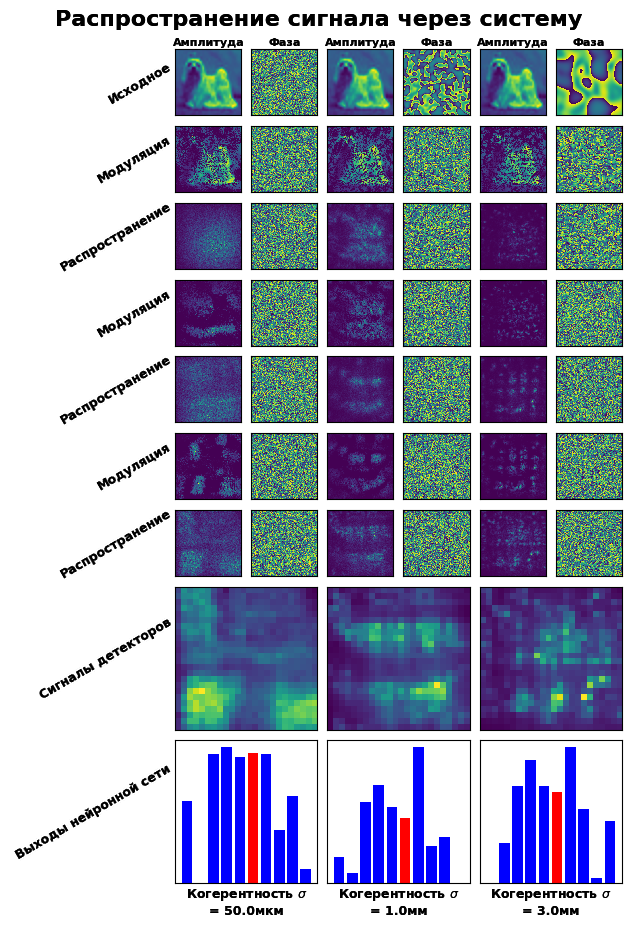

In [27]:
image, label = next(iter(dataset.test))
image, label = image[0].unsqueeze(0).to(optical_list[0].device), label[0].to(optical_list[0].device)
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = deepcopy(FontLibrary)
plot.FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 8
plot.FontLibrary.Fonts.RowDescriptionRight.FontSize = 10
plot.FontLibrary.Fonts.RowDescriptionLeft.Rotation = 30
plot.pad.graph.vertical(0.1)
plot.pad.graph.horizontal(0.1)
plot.title("Распространение сигнала через систему")

with torch.no_grad():
    for col, (spatial_coherence, optical, detectors, electronic) in enumerate(zip(spatial_coherence_list, optical_list, detectors_list, electronic_list)):
        col0 = 2*col
        col1 = col0 + 1

        plot.description.column.bottom(f"Когерентность $\\sigma$ = {engineering(spatial_coherence, 'м', 0, space='')}", col0, col1)
        plot.description.column.top("Амплитуда", col0)
        plot.description.column.top("Фаза", col1)
        
        planes_ = optical.planes(image, image.shape[2], image.shape[3])
        planes = [planes_[0]] + [x for i, x in enumerate(planes_[1:]) if i % 3 != 0]
        for row, plane in enumerate(planes):
            if col == 0:
                if row == 0:
                    plot.description.row.left("Исходное", row)
                elif row % 2 == 0:
                    plot.description.row.left("Распространение", row)
                else:
                    plot.description.row.left("Модуляция", row)
            axes = plot.axes.add(col0, row)
            axes.imshow(plane.squeeze().cpu().abs(), aspect='auto', interpolation='nearest')
            axes.set_xticks([])
            axes.set_yticks([])
            
            axes = plot.axes.add(col1, row)
            axes.imshow(plane.squeeze().cpu().angle(), aspect='auto', interpolation='nearest')
            axes.set_xticks([])
            axes.set_yticks([])

        if col == 0:
            plot.description.row.left("Сигналы детекторов", row+1, row+2)
            plot.description.row.left("Выходы нейронной сети", row+3, row+4)
            
        signals = detectors.forward(optical.forward(image))
        axes = plot.axes.add((col0, row+1), (col1, row+2))
        axes.set_xticks([])
        axes.set_yticks([])
        axes.imshow(signals.squeeze().cpu(), aspect='auto', interpolation='nearest')
        
        results = electronic.forward(signals)
        colors = ['blue']*results.squeeze().shape[0]
        colors[label] = 'red'
        axes = plot.axes.add((col0, row+3), (col1, row+4))
        axes.set_xticks([])
        axes.set_yticks([])
        axes.bar(numpy.arange(results.squeeze().shape[0]), ((results - results.min())/(results.max() - results.min())).squeeze().cpu(), color=colors)
        
plot.save('../../figures/ModelWork3.pdf')
plot.show()